In [99]:
import numpy as np
import GPy

import logging
logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

import warnings
warnings.filterwarnings('ignore')

Double check that the user function (that provides the data points) returns the appropriate format.

Here, User function (that we want to estimate) should return 2d array or a tuple of 2d arrays 

In [101]:
from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

f, _ = branin_function() # or branin()

def branin(x, noise_level=0.):
    return np.reshape(_branin(x) + noise_level * np.random.randn(), (-1,1))

Initial design / data points

In [31]:
shape = (100, 1)
X0 = np.random.randint(-5, 10, shape)
X1 = np.random.randint(0, 15, shape)
X = np.concatenate((X0, X1), axis=1)
Y = np.reshape(np.append([], [branin(x) for x in X]), (-1, 1))

# or use RandomDesign
parameter_space = ParameterSpace([ContinuousParameter(
    'x1', -5, 10), ContinuousParameter('x2', 0, 15)])
design = RandomDesign(parameter_space)
if not X:
    num_data_points = shape[0]
    X = design.get_samples(num_data_points)

Plotting initial design values

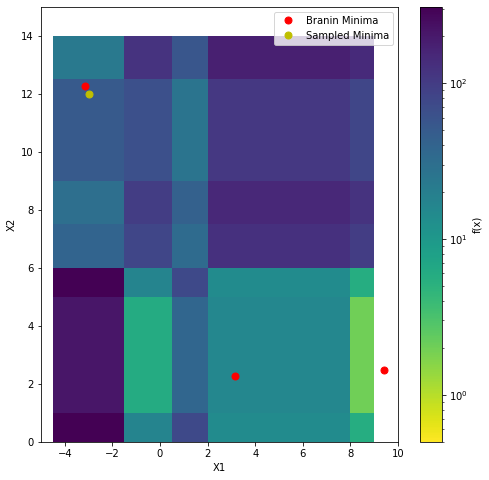

In [104]:
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt



x_ax, y_ax = np.meshgrid(X0, X1)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([branin(val) for val in vals], (shape[0], shape[0]))
fig, ax = plt.subplots(figsize=(8,8))
cm = ax.pcolormesh(x_ax, y_ax, fx,
                   norm=LogNorm(vmin=fx.min(),
                                vmax=fx.max()),
                   cmap='viridis_r')

minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
found_minima = np.reshape([x_ax[np.where(fx == np.min(fx))][0], y_ax[np.where(fx == np.min(fx))][0]], (1, 2))


ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
        lw=0, label="Branin Minima")
ax.plot(found_minima[:, 0], found_minima[:, 1], "y.", markersize=14,
        lw=0, label="Sampled Minima")

cb = fig.colorbar(cm)
cb.set_label("f(x)")

ax.legend(loc="best", numpoints=1)

ax.set_xlabel("X1")
ax.set_xlim([-5, 10])
ax.set_ylabel("X2")
ax.set_ylim([0, 15])

plt.show()

Initialize Emulator Model

In [ ]:
gpy_model = GPy.models.GPRegression(X, Y)
gpy_model.optimize()
model_emukit = GPyModelWrapper(gpy_model)

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


# Decision Loop

In [10]:
# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
from emukit.quadrature.acquisitions import IntegralVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

In [36]:
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model=model_emukit)
optimizer = GradientAcquisitionOptimizer(space=parameter_space)


In [85]:
# Create the Bayesian optimization object
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=expected_improvement,
                                         batch_size=3)

INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator


In [86]:
# Run the loop and extract the optimum
# Run the loop until we either complete 10 steps or converge
stopping_condition = FixedIterationsStoppingCondition(
    i_max=10) | ConvergenceStoppingCondition(eps=0.01)

bayesopt_loop.run_loop(branin, stopping_condition)


INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <cl

In [87]:
initial_design_samples = shape[0]
new_Y = bayesopt_loop.loop_state.Y[initial_design_samples:, :]
new_X = bayesopt_loop.loop_state.X[initial_design_samples:, :]


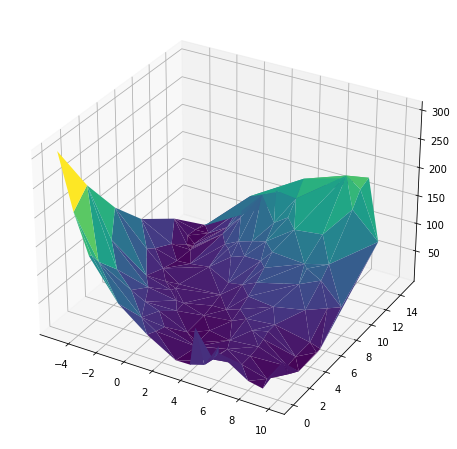

In [100]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

zline = bayesopt_loop.loop_state.Y.flatten()
xline = bayesopt_loop.loop_state.X[:, 0]
yline = bayesopt_loop.loop_state.X[:, 1]
ax.plot_trisurf(xline, yline, zline, cmap='viridis')
plt.show()

(0.0, 15.0)

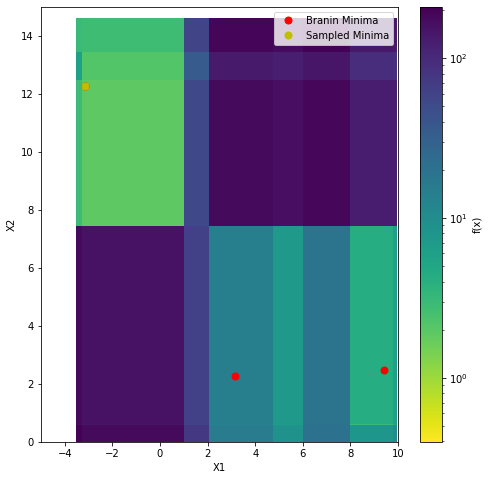

In [105]:
x_ax, y_ax = np.meshgrid(new_X[:, 0], new_X[:, 1])
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([branin(val) for val in vals], x_ax.shape)

fig, ax = plt.subplots(figsize=(8, 8))
cm = ax.pcolormesh(x_ax, y_ax, fx,
                   norm=LogNorm(vmin=fx.min(),
                                vmax=fx.max()),
                   cmap='viridis_r')

minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])

found_minima = new_X[np.where((new_Y == np.min(new_Y)))[0]]


ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
        lw=0, label="Branin Minima")
ax.plot(found_minima[:, 0], found_minima[:, 1], "y.", markersize=14,
        lw=0, label="Sampled Minima")

cb = fig.colorbar(cm)
cb.set_label("f(x)")

ax.legend(loc="best", numpoints=1)

ax.set_xlabel("X1")
ax.set_xlim([-5, 10])
ax.set_ylabel("X2")
ax.set_ylim([0, 15])
